In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import poisson, nbinom
import seaborn as sns
import pandas as pd

from Model_less_weird import Model
from PlaceInputs import PlaceInputs
from utils import *
import configs

# Parameters and Initialization

In [8]:
# Parameters
N_inp = 10000
N_bar = 10000
num_states = 100
steps = 100
start_t = steps-25 # Start of time window

In [9]:
cache_states = [25, 75]
forget_state = 75

# Run Task (with learning)

Now I just cached at location: 25
Now I just cached at location: 75
Recall after cache at sites 25 and 75:


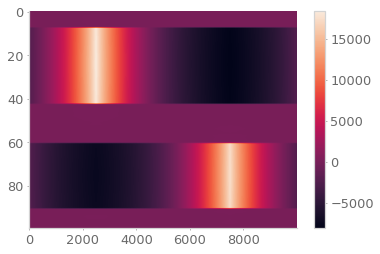

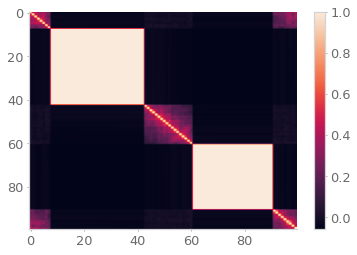

Recall after forgetting at site 75:


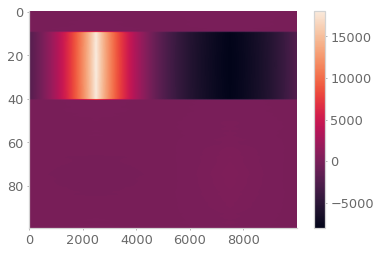

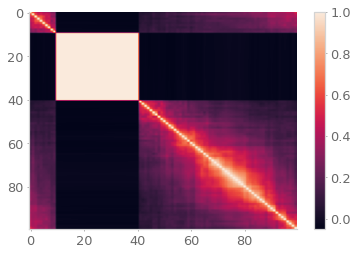

Recall after re-cache at site 75:


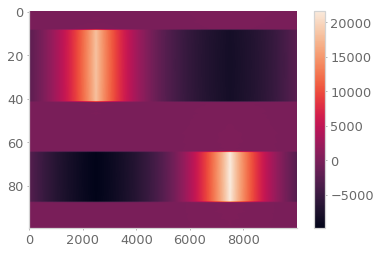

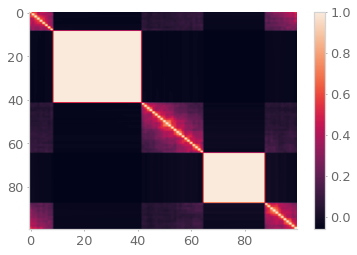

Recall after forgetting at site 75:


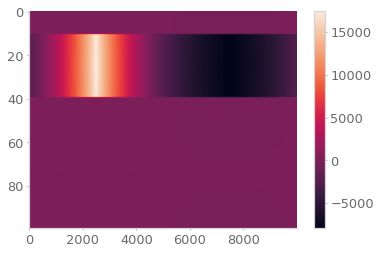

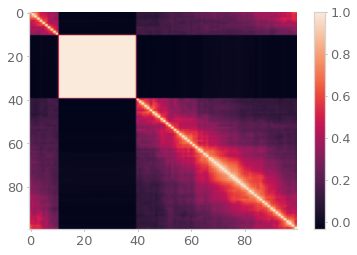

Recall after re-cache at site 75:


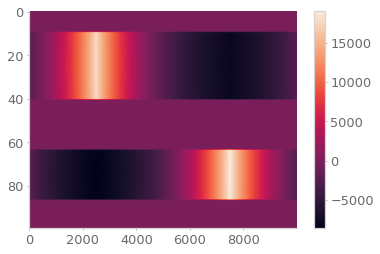

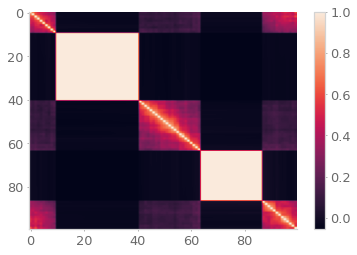

KeyboardInterrupt: 

In [10]:
def get_avg_cache_acts(cache_acts_over_time):
    avg_cache_acts = []
    for i in range(len(cache_acts_over_time)):
        location = cache_states[i]
        vec = cache_acts_over_time[i][start_t:steps, location, :].mean(axis=0)
        avg_cache_acts.append(vec)
    avg_cache_acts = np.array(avg_cache_acts)
    return avg_cache_acts

def show_recall():
    _, recall_acts, recall_reconstruct, recall_acts_over_time = model.run_recall(
    1.0, place_inputs, n_zero_input=0)
    plt.figure()
    plt.imshow(recall_reconstruct, aspect='auto')
    plt.colorbar()
    plt.show()
    plt.imshow(np.corrcoef(recall_acts), aspect='auto')
    plt.colorbar()
    plt.show()
    
    
model = Model(
    N_inp, N_bar, num_states,
    steps=steps,
    divisive_normalization=20.0,
    forget_readout_lr=0.25, forget_lr=3.5, forget_plasticity_bias=-2.25
)
    
place_inputs = PlaceInputs(N_inp, num_states).get_inputs()

    
model.reset()
cache_acts = []
cache_acts_over_time = []
retrieval_acts = []
retrieval_acts_over_time = []
projs = []
outs = []
recons = []
for cache_state in cache_states:
    print("Now I just cached at location:", cache_state)
    preacts, acts, _, acts_over_time = model.run_recurrent(place_inputs, n_zero_input=20)
    model.update(place_inputs[cache_state], acts[cache_state], preacts[cache_state])
    if cache_state == forget_state:
        cache_acts.append(acts[forget_state].copy())
        cache_acts_over_time.append(acts_over_time[forget_state].copy())
    

print("Recall after cache at sites 25 and 75:")
show_recall()



num_repeats = 20

for r in range(num_repeats):
    
    #'''
    preacts, acts, _, acts_over_time = model.run_recurrent(place_inputs, n_zero_input=20)
    #act_normalized = acts_over_time[steps-1][forget_state] / np.linalg.norm(acts_over_time[steps-1][forget_state])
    act_normalized = acts[forget_state] / np.linalg.norm(acts[forget_state])

    recon = np.dot(model.J_xy, acts[forget_state])
    outs.append(np.dot(model.J_xy, act_normalized) / np.linalg.norm(acts[forget_state]))
    recons.append(recon)
    projs.append(np.dot(model.J_xx, act_normalized) / np.linalg.norm(acts[forget_state]))
    #model.J_xy -= np.dot(model.J_xy, act_normalized)[:, None] * act_normalized[None, :]
    #model.J_xy -= 0.01 * np.dot(model.J_xy, act_normalized)[:, None] * acts[forget_state][None, :]
    #model.J_xy -= 0.3 * recon[:, None] * acts[forget_state][None, :] / N_bar

    #model.J_xy -= (0.002*acts[forget_state][:, None] - 0.004) * acts[forget_state][None, :]
    
    #plt.show()
    #place_inputs -= 0.005*acts[forget_state][None, :]
    #change = model.J_xx - model.J_xx_orig
    #change -= 4.0*(acts[forget_state][:, None] - 2.0) * acts[forget_state][None, :] / N_bar
    #change -= np.dot(model.J_xx, act_normalized)[:, None] * act_normalized[None, :]
    #change += 0.0001*np.matmul(np.ones_like(acts_over_time[steps-1][forget_state].transpose())*model.plasticity_bias, acts_over_time[steps-1][forget_state])
    #change -= np.dot(act_normalized, model.J_xx)[None, :] * act_normalized[:, None]
    #model.J_xx = model.J_xx - 4.0*(acts[forget_state][:, None] - 2.0) * acts[forget_state][None, :] / N_bar
    
    model.reverse_update(acts[forget_state])
    
    retrieval_acts.append(acts[forget_state].copy())
    retrieval_acts_over_time.append(acts_over_time[forget_state].copy())
    
    print("Recall after forgetting at site 75:")
    show_recall()
    #'''
    
    preacts, acts, _, acts_over_time = model.run_recurrent(place_inputs, n_zero_input=20)
    model.update(place_inputs[forget_state], acts_over_time[steps-1][forget_state], preacts[forget_state])
    cache_acts.append(acts[forget_state].copy())
    cache_acts_over_time.append(acts_over_time[forget_state].copy())
    print("Recall after re-cache at site 75:")
    
    show_recall()

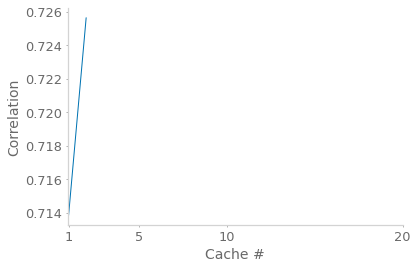

In [11]:
def cross_corr_from_pairwise(pairwise):
    results = []
    for i in range(1, len(pairwise)):
        results.append(np.nanmean(np.diagonal(pairwise, offset=i)))
    return results

plt.plot(range(1, len(cache_acts)), cross_corr_from_pairwise(np.corrcoef(np.concatenate([cache_acts], axis=0))))
plt.xticks([1, 5, 10, 20])
plt.xlabel("Cache #")
plt.ylabel("Correlation")
plt.show()

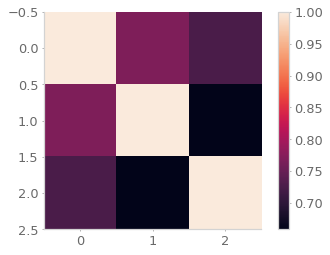

In [12]:
plt.imshow(np.corrcoef(np.concatenate([cache_acts], axis=0)))
plt.colorbar()
plt.show()

In [15]:
from scipy.stats import linregress
for i in range(5):
    slope, intercept, r, _, _ = linregress(retrieval_acts[i], projs[i])
    print(slope*N_bar, intercept*N_bar, r)

3.904134225154541 -10.900209716462312 0.8730321455938386
3.245875715808042 -8.65106515702544 0.8859611909379661


IndexError: list index out of range

In [14]:
from scipy.stats import linregress
for i in range(5):
    slope, intercept, r, _, _ = linregress(recons[i], outs[i])
    print(slope*N_bar, intercept*N_bar, r)

0.2781670133370346 1.28779162883553e-13 1.0
0.2237758857665034 -3.2198436126627355e-14 1.0


IndexError: list index out of range

In [108]:
for i in range(10):
    print(np.sum(cache_acts[i]))
    print(np.sum(retrieval_acts[i]))
    print('***')

203.24220117153382
942.734724012024
***
231.93236983820745
782.4962536521845
***
219.39879647746852
1022.0501218304247
***
237.25923757577863
785.177933472306
***
246.6651395925732
1189.7372735096078
***
202.67933793223736
588.317815573506
***
255.64521370529405
1894.4999780822156
***


IndexError: list index out of range

In [107]:
for i in range(5):
    print(np.corrcoef(cache_acts[i], retrieval_acts[i])[0, 1])
    #print(np.corrcoef(cache_acts[i+1], retrieval_acts[i])[0, 1])
    print('**')

0.9774090924415392
**
0.7308224478884775
**
0.7476303354245719
**
0.7830203734048468
**
0.7569435855213332
**


In [24]:
model.J_xy.shape

(2000, 2000)

In [16]:
for i in range(5):
    print(np.mean(cache_acts[i]))

0.07053208808062433
0.06644263141658678
0.07040034455481138


IndexError: list index out of range

In [ ]:
    #act_normalized = acts_over_time[steps-1][forget_state] / np.linalg.norm(acts_over_time[steps-1][forget_state])
    #act_normalized = acts[forget_state] / np.linalg.norm(acts[forget_state])

    #recon = np.dot(model.J_xy, acts[forget_state])
    #outs.append(np.dot(model.J_xy, act_normalized) / np.linalg.norm(acts[forget_state]))
    #recons.append(recon)
    #projs.append(np.dot(model.J_xx, act_normalized) / np.linalg.norm(acts[forget_state]))
    #model.J_xy -= np.dot(model.J_xy, act_normalized)[:, None] * act_normalized[None, :]
    #model.J_xy -= 0.01 * np.dot(model.J_xy, act_normalized)[:, None] * acts[forget_state][None, :]
    #model.J_xy -= 0.3 * recon[:, None] * acts[forget_state][None, :] / N_bar

    #model.J_xy -= (0.002*acts[forget_state][:, None] - 0.004) * acts[forget_state][None, :]
    
    #plt.show()
    #place_inputs -= 0.005*acts[forget_state][None, :]
    #change = model.J_xx - model.J_xx_orig
    #change -= 4.0*(acts[forget_state][:, None] - 2.0) * acts[forget_state][None, :] / N_bar
    #change -= np.dot(model.J_xx, act_normalized)[:, None] * act_normalized[None, :]
    #change += 0.0001*np.matmul(np.ones_like(acts_over_time[steps-1][forget_state].transpose())*model.plasticity_bias, acts_over_time[steps-1][forget_state])
    #change -= np.dot(act_normalized, model.J_xx)[None, :] * act_normalized[:, None]
    #model.J_xx = model.J_xx - 4.0*(acts[forget_state][:, None] - 2.0) * acts[forget_state][None, :] / N_bar